Continues the cleaning data

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os

#Import dataset
time_series = pd.read_csv('dataset/parcial_time_series.csv', sep = ';', index_col = 0)

#We notice that we don`t have suficient data to deal with Sorghum,Açaí,Palm Oil and Soy. So, we find another dataset in https://sidra.ibge.gov.br/tabela/5457
#Import this dataset
extern_dataset = pd.read_csv('dataset/extern_dataset.csv', sep = ';', nrows = 5563, header = 4)

In [2]:
# Version that we used in this notebook
!pip install -q watermark
%reload_ext watermark
%watermark --iversions

pandas    : 1.3.4
numpy     : 1.20.3
matplotlib: 3.4.3
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]



Select the lines and columns that we want in extern_dataset and makes a time series

In [3]:
#Select the lines
keys = []
for key,line in extern_dataset.iterrows():
    if '(PA)' in line['Município']:
        keys.append(key)
extern_dataset = extern_dataset.iloc[keys,:]

In [4]:
#Select the columns and add the year
#Create the dataset
aux_df = []
for i in range(9):
    aux_df.append(pd.DataFrame([], columns = ['city_code'] + list(map(lambda x: str(x),[i for i in range(1997,2021)])) + ['product']))

#Complete the dataset    
for j in range(1,10):
    temporary_df = extern_dataset.iloc[:,[0] + [i for i in range(j,217,9)]].copy()
    temporary_df.loc[:,'product'] = extern_dataset.columns[j] 
    temporary_df.columns = ['city_code'] + list(map(lambda x: str(x),[i for i in range(1997,2021)])) + ['product']
    aux_df[j-1] = pd.concat([aux_df[j-1],temporary_df])

#Concatenate
extern_time_series = pd.concat(aux_df)
extern_time_series.reset_index(inplace = True)
extern_time_series = extern_time_series.iloc[:,1:]

#Select the years in (1997,2017)
extern_time_series = extern_time_series.iloc[:,list(set(range(26))-{24,23,22})].copy()

In [5]:
#Fix the products names
product_name = {'Açaí': 'Açaí','Sorgo (em grão)': 'Sorghum','Arroz (em casca)': 'Rice',
                'Cacau (em amêndoa)': 'Cocoa','Dendê (cacho de coco)': 'Palm oil','Mandioca': 'Cassava',
                'Milho (em grão)': 'Corn','Soja (em grão)': 'Soy','Feijão (em grão)': 'Beans'}

for index,line in extern_time_series.iterrows():
    extern_time_series.loc[index,'product'] = product_name.get(line['product'])

In [6]:
#Replace the values
sum = 0
for index,line in extern_time_series.iterrows():
    for position in range(1,22):
        sum += 1
        if line.iloc[position] == "-":
            extern_time_series.iloc[index,position] = 0
        elif line.iloc[position] == "..":
            extern_time_series.iloc[index,position] = np.NaN
        elif line.iloc[position] == "...":
            extern_time_series.iloc[index,position] = np.NaN
        else:
            extern_time_series.iloc[index,position] = float(line.iloc[position])

In [7]:
#How much na lines has na values in 2016 and 2017?
time_series.iloc[:,[19,20]].isna().sum()

19    633
20    663
dtype: int64

Make a standard df to analysis data

In [8]:
#Makes a df in the standard format
df = pd.DataFrame([],columns = ['city_code','destinated_area', 'product','year'])
for i in range(1,22):
    sub_df = extern_time_series.iloc[:,[0,i,22]].copy()
    sub_df.loc[:,'year'] = str(1996 + i)
    sub_df.columns = ['city_code','destinated_area', 'product','year']
    df = pd.concat([df,sub_df])
df.reset_index(inplace = True)
df = df.iloc[:,1::]

Graphic Analysis

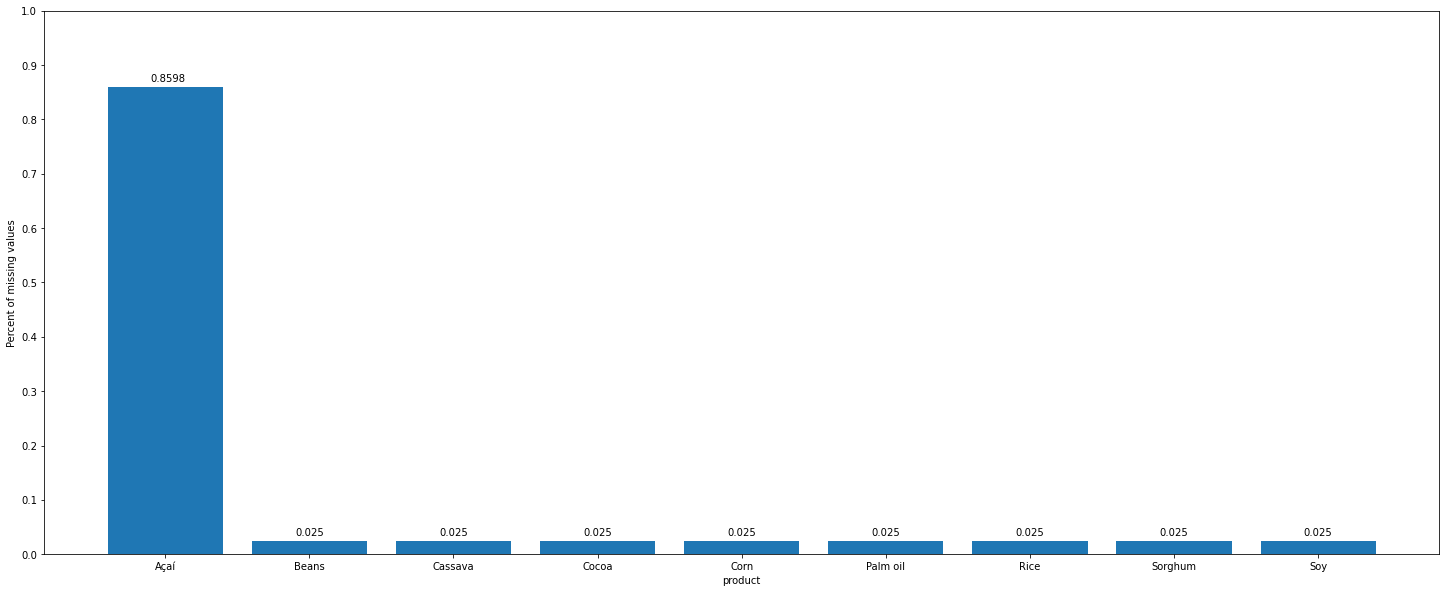

In [9]:
#percent of missing values per year
percent_missing_values_per_product = []
products = []
for product,sub_df in df.groupby('product'):
    percent_missing_values_per_product.append(1 - sub_df.destinated_area.isna().value_counts()[0]/len(sub_df))
    products.append(product)

#Grapich
_ = plt.figure(figsize = (25,10))
plt.xlabel('product')
plt.ylabel('Percent of missing values')
plt.bar(products,percent_missing_values_per_product)
plt.yticks(np.linspace(0,1,11))
for i,j in enumerate(percent_missing_values_per_product):
    plt.text(i-.1,j+.01,str(round(j,4)))

plt.show()

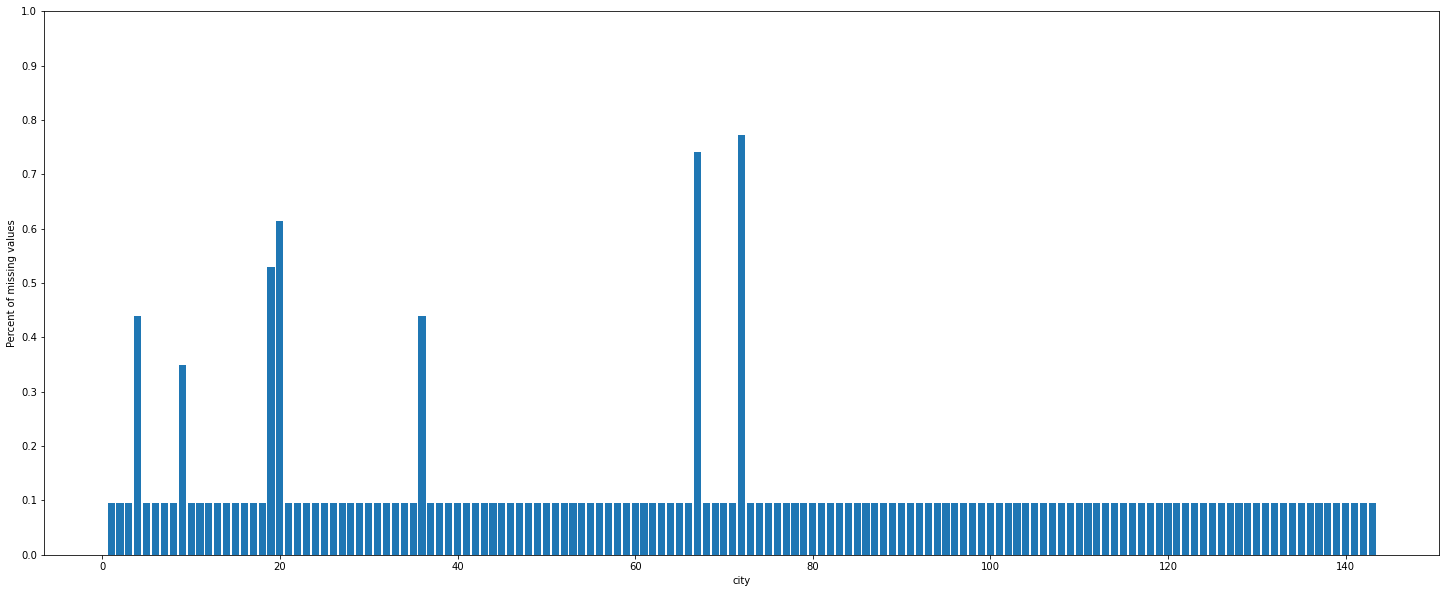

In [10]:
#percent of missing values per city_code
percent_missing_values_per_city = []
for city,sub_df in df.groupby('city_code'):
    percent_missing_values_per_city.append(1 - sub_df.destinated_area.isnull().value_counts()[0]/len(sub_df))

#Grapich
_ = plt.figure(figsize = (25,10))
plt.xlabel('city')
plt.ylabel('Percent of missing values')
plt.bar(range(1,len(percent_missing_values_per_city)+1),percent_missing_values_per_city)
plt.yticks(np.linspace(0,1,11))
plt.show()

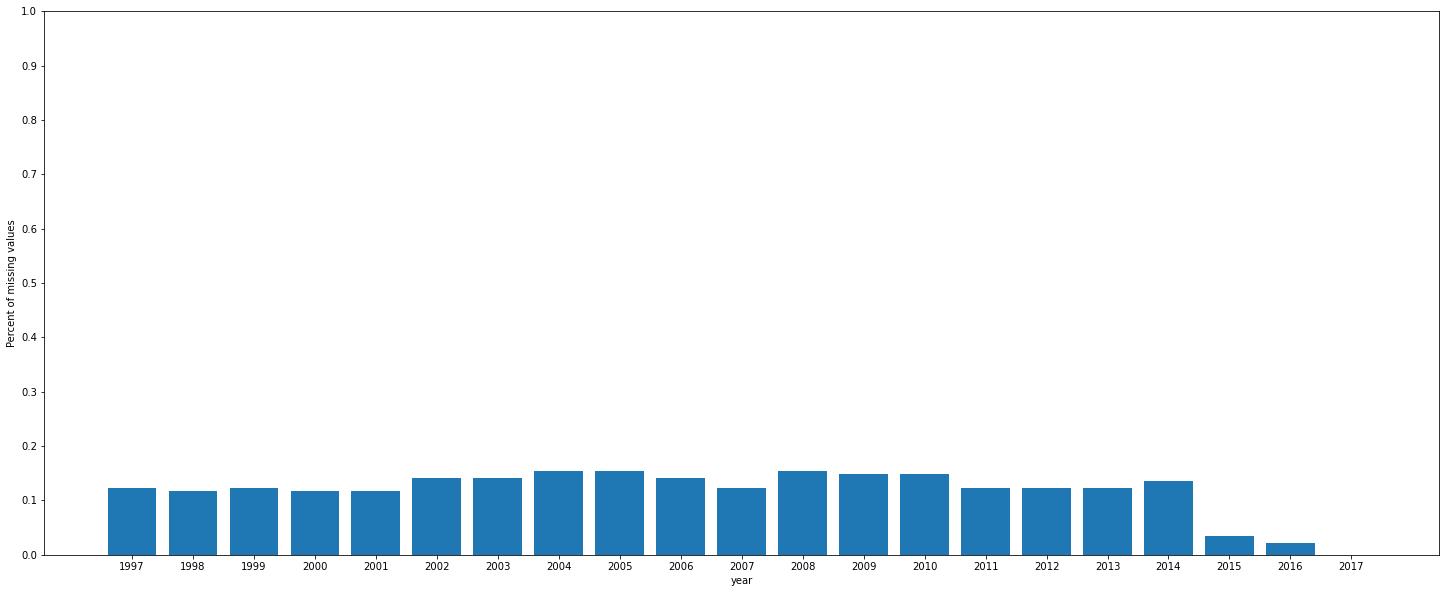

In [11]:
#percent of missing values per year
percent_missing_values_per_year = []
years = []
for year,sub_df in df.groupby('year'):
    percent_missing_values_per_year.append(0 if len(sub_df.destinated_area.isna().value_counts()) == 1 else sub_df.destinated_area.isna().value_counts()[1]/len(sub_df))
    years.append(year)

#Grapich
_ = plt.figure(figsize = (25,10))
plt.xlabel('year')
plt.ylabel('Percent of missing values')
plt.bar(years,percent_missing_values_per_year)
plt.yticks(np.linspace(0,1,11))
plt.show()

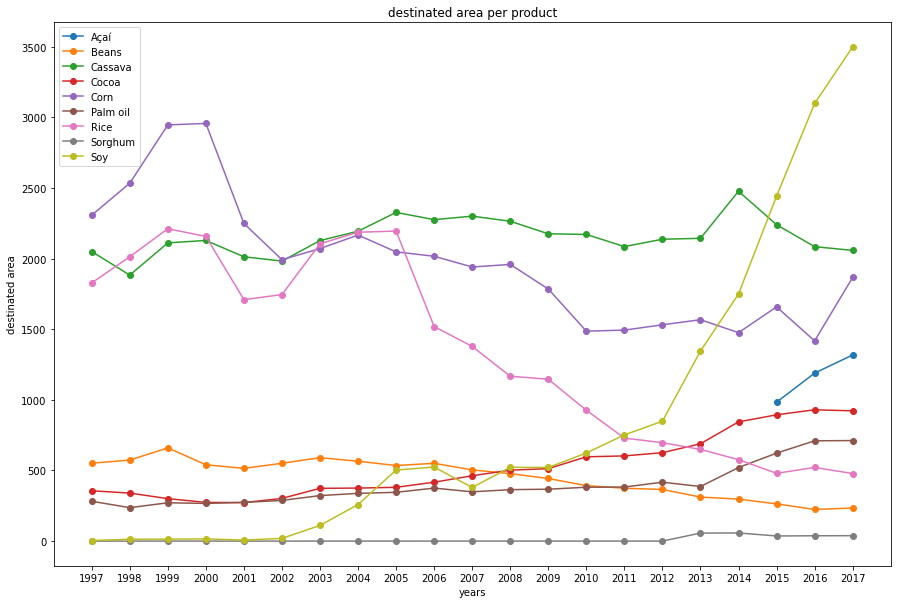

In [12]:
#Behavior of products in the year (mean) extern data

#Caculate the mean
means = []
products = []
for product,sub_df in extern_time_series.fillna(-1).groupby('product'):
    mean = []
    for i in range(1,22):
        count = 0
        value = 0
        for j in range(len(sub_df.iloc[:,i])):
            if sub_df.iloc[j,i] != -1:
                count += 1
                value += sub_df.iloc[j,i]
        mean.append(np.NaN if count == 0 else value/count)
    products.append(product)
    means.append(mean)

#Plot graphic
plt.figure(figsize = (15,10))
legends = []
for product,mean in zip(products,means):
    plt.plot([i+1997 for i in range(21)],mean,marker = 'o')
    legends.append(product)

plt.xlabel('years')
plt.ylabel('destinated area')
plt.title('destinated area per product')
plt.xticks(np.arange(1997,2018,step = 1))
plt.legend(legends)
plt.show()

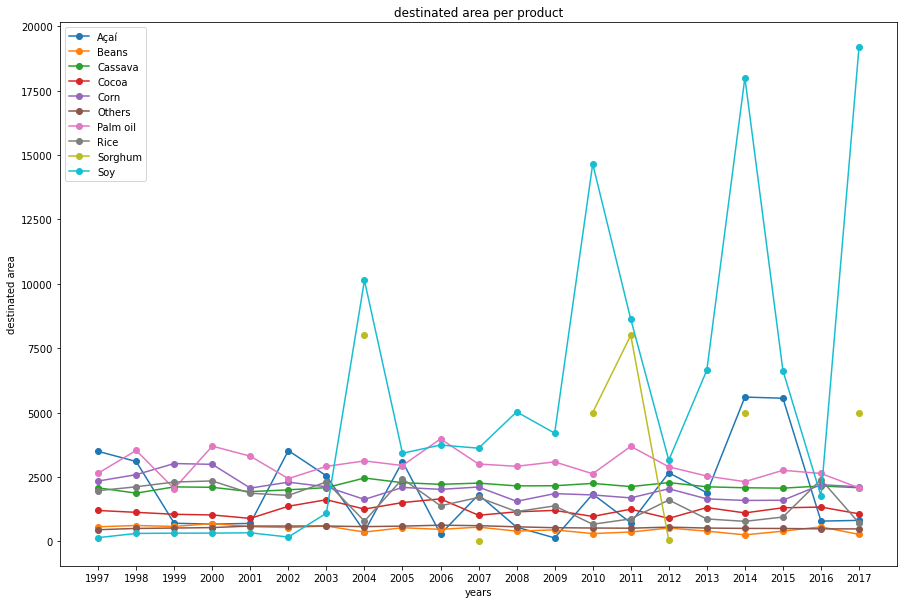

In [13]:
#Let's compare with the data that we have
means = []
products = []
for product,sub_df in time_series.loc[time_series['product'] != 'Livestock'].groupby('product'):
    products.append(product)
    means.append(sub_df.iloc[:,0:21].mean())

#Plot graphic
plt.figure(figsize = (15,10))
legends = []
for product,mean in zip(products,means):
    plt.plot(np.arange(1997,2018,step = 1),mean,marker = 'o')
    legends.append(product)


plt.xlabel('years')
plt.ylabel('destinated area')
plt.title('destinated area per product')
plt.legend(legends)
plt.xticks(np.arange(1997,2018,step = 1))
plt.show()

Sorghum

In [14]:
#The sorhum in extern time series is always 0, so we will replace all the values with 0, only one line that have higher values
sorghum = time_series.loc[time_series['product'] == 'Sorghum']
time_series = time_series.loc[time_series['product'] != 'Sorghum']
special_line_sorghum = sorghum.loc['48/Sorghum/temporary',:].copy()
sorghum = sorghum.loc[sorghum['product']  != '48/Sorghum/temporary'].copy()

#Imput with 0 sorghum
sorghum = sorghum.fillna(0)

#Imput speical_line with 5000
special_line_sorghum = special_line_sorghum.fillna(5000)

time_series = pd.concat([time_series,pd.DataFrame([list(special_line_sorghum)],index = ['48/Sorghum/temporary'], columns = sorghum.columns),sorghum])

Geral overview

In [15]:
#Define a function to generate a graph
#Generate graphs per city, to look the behavior of destinated_are per year
def generate_graph(city,sub_df_per_city,directory,scale,limit):
    #Make the graph
    fig = plt.figure(figsize = (15,10))

    #Sets of graph
    plt.title(f'Destinated area per product in {city}')
    plt.xlabel('years')
    plt.ylabel('destinated area')
    plt.grid()
    legends = []
    count = 0

    #Plot line without mising values
    for _,line in sub_df_per_city.fillna(-1).iterrows():
        plt.plot([i+1997 for i in range(10,21)],line.iloc[11:22], marker = 'o')
        #legends.append(line.iloc[0])

    #Plot the mean of the city
    plt.plot([i+1997 for i in range(10,21)],sub_df_per_city.iloc[:,11:22].mean(),'r--',marker = 'o',label = 'city mean')

    plt.ylim(limit)
    plt.yticks(scale)
    plt.xticks(np.arange(2007,2018,step = 1))
    plt.legend(legends)
    plt.close()
    plt.show()

    #Save in a different directory
    if directory != None:
        local_save = os.path.join(os.path.abspath("."), f"graphics{os.sep}",(directory+os.sep),f"product_{city}.png")
        fig.savefig(local_save, dpi = fig.dpi)

In [16]:
#Look the behavior of products in the years 2007 to 2017
directory = "destinated_area_per_product_extern_data"
scale = np.arange(0,15000,1000)
limit = (0,10000)

for city,sub_df_per_city in extern_time_series.groupby('product'):
    generate_graph(city,sub_df_per_city,directory,scale,limit)

In [17]:
#Create a column that is the mean of the line
extern_time_series.loc[:,'mean'] = 0
for key,line in extern_time_series.iterrows():
    extern_time_series.iloc[key,23] = line.iloc[1:22].mean()

time_series.loc[:,'mean'] = 0
for key,line in time_series.iterrows():
    time_series.loc[key,'mean'] = line.iloc[0:21].mean()

Palm oil

In [18]:
#Export this datasets to compare in a csv file, it`s easier to look
extern_time_series.loc[extern_time_series['product'] == 'Palm oil'].to_csv('view_dataset/extern_time_series_Palmoil.csv', sep = ';') 
time_series.loc[time_series['product'] == 'Palm oil'].to_csv('view_dataset/time_series_Palmoil.csv',sep = ';')

In [19]:
#In the lines that we don`t have any information it`s worth to imput 0. Because in extern_time_series there is a lot of lines with only 0
auxiliar_time_series = time_series.loc[time_series['product'] == 'Palm oil'].copy()
time_series = time_series.loc[time_series['product'] != 'Palm oil'].copy()

#Imput 0
#Identify the lines that only have na values
na_line = []
for key,line in auxiliar_time_series.iloc[:,0:21].isna().iterrows():
    null_line = True
    for i in range(21):
        if line.iloc[i] == False:
            null_line = False
    if null_line:
        na_line.append(key)

part_1_time_series = auxiliar_time_series.loc[na_line,:].copy()
part_1_time_series = part_1_time_series.fillna(0)
part_2_time_series = auxiliar_time_series.loc[list(set(auxiliar_time_series.index)-set(na_line)),:].copy()         

In [20]:
#Now we will divide the part_2_time_series in two datasets, because one part of this data has few na values
#In the csv we notice that this lines has a lot of data

lines_with_lot_of_data = ['100/Palm oil/permanent','101/Palm oil/permanent','113/Palm oil/permanent','115/Palm oil/permanent','120/Palm oil/permanent',
'131/Palm oil/permanent','14/Palm oil/permanent','140/Palm oil/permanent','15/Palm oil/permanent','23/Palm oil/permanent',
'27/Palm oil/permanent','35/Palm oil/permanent','43/Palm oil/permanent','5/Palm oil/permanent',
'60/Palm oil/permanent','62/Palm oil/permanent','78/Palm oil/permanent','80/Palm oil/permanent']

lines_with_few_data = list(set(part_2_time_series.index)-set(lines_with_lot_of_data))


part_3_time_series = part_2_time_series.loc[lines_with_lot_of_data,:].copy()
part_2_time_series = part_2_time_series.loc[lines_with_few_data,:].copy()

part_2_time_series

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,city_code,product,product_type,mean
34/Palm oil/permanent,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,...,NaN,2500.0,NaN,2400.0,NaN,NaN,40abcc3eff7bcf73,Palm oil,permanent,2270.000000
58/Palm oil/permanent,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68f01d67ad163f32,Palm oil,permanent,40.000000
25/Palm oil/permanent,NaN,1100.0,1000.0,NaN,NaN,NaN,NaN,1988.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2631530645ac2ec8,Palm oil,permanent,1362.666667
90/Palm oil/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1547.0,NaN,...,NaN,1547.0,NaN,NaN,NaN,850.0,902f3a9003f7e637,Palm oil,permanent,1314.666667
53/Palm oil/permanent,100.0,100.0,NaN,NaN,NaN,NaN,230.0,100.0,NaN,NaN,...,100.0,100.0,NaN,NaN,NaN,NaN,60982e0f7928740a,Palm oil,permanent,151.428571
92/Palm oil/permanent,2500.0,2000.0,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2000.0,960b4f2c94a2fb2c,Palm oil,permanent,2100.000000
91/Palm oil/permanent,NaN,90.0,65.0,NaN,NaN,NaN,NaN,65.0,NaN,NaN,...,80.0,NaN,NaN,65.0,NaN,NaN,93656feaf53efbef,Palm oil,permanent,73.000000
64/Palm oil/permanent,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72b65b337fc5302a,Palm oil,permanent,350.000000
125/Palm oil/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,100.0,NaN,d0f5f5b9fcecb0d8,Palm oil,permanent,100.000000
105/Palm oil/permanent,NaN,35.0,NaN,NaN,35.0,NaN,35.0,NaN,NaN,NaN,...,35.0,NaN,35.0,NaN,35.0,35.0,abcadd700f8948e3,Palm oil,permanent,35.000000


In [21]:
#Handle with lines that contais high values
#Line 90/Palm oil/permanent   25/Palm oil/permanent  52/Palm oil/permanent
#Look the series that have mean in [1000,1500]
palmoil_extern = extern_time_series.loc[extern_time_series['product'] == 'Palm oil'].copy()
aux_df = palmoil_extern.loc[palmoil_extern['mean'] > 1000]
aux_df = aux_df.loc[aux_df['mean'] <= 1500]
mean = aux_df.iloc[:,1:22].mean()

for i in range(0,21):
    if part_2_time_series.loc['90/Palm oil/permanent',:].isna().iloc[i] == True:
        part_2_time_series.loc['90/Palm oil/permanent',str(i)] = mean[i]
    if part_2_time_series.loc['25/Palm oil/permanent',:].isna().iloc[i] == True:
        part_2_time_series.loc['25/Palm oil/permanent',str(i)] = mean[i]
    if part_2_time_series.loc['52/Palm oil/permanent',:].isna().iloc[i] == True:
        part_2_time_series.loc['52/Palm oil/permanent',str(i)] = mean[i]

In [22]:
#The rest of the line`s values is very constant, so we will input with linear regression 
#Complete the prepare_df with linear regression
for key,line in part_2_time_series.fillna(-1).iterrows():
    missing_values = set()
    need_linear_regression = False
    for position in range(0,21):
        if line.iloc[position] == -1:
            need_linear_regression = True
            missing_values.add(position)
    if need_linear_regression:
        x = list({i for i in range(0,21)} - missing_values)
        y = line.iloc[x]
        line = LinearRegression()
        line.fit(np.array(x).reshape(-1,1),y)
        results = line.predict(np.array(list(missing_values)).reshape(-1,1))
        for x_position,result in zip(list(missing_values),list(results)):
            if result < 0:
                part_2_time_series.loc[key,str(x_position)] = 0
            else:
                part_2_time_series.loc[key,str(x_position)] = result

#Concatenate with the rest of df
time_series = pd.concat([part_2_time_series,part_3_time_series,part_1_time_series,time_series])

Soy

In [23]:
#We will look now to Soy
soy = time_series.loc[time_series['product'] == 'Soy'].copy()
time_series = time_series.loc[time_series['product'] != 'Soy']

#Export this datasets to compare in a csv file, it`s easier to look,because don`t have a lot of lines
extern_time_series.loc[extern_time_series['product'] == 'Soy'].to_csv('view_dataset/extern_time_series_Soy.csv', sep = ';') 
soy.to_csv('view_dataset/time_series_Soy.csv',sep = ';')

In [24]:
#We notice that there is a lot of lines with only 0, so the lines in soy that we don`t have any infromation, we will replace with 0
#Imput 0
#Identify the lines that only have na values
na_line = []
for key,line in soy.iloc[:,0:21].isna().iterrows():
    null_line = True
    for i in range(21):
        if line.iloc[i] == False:
            null_line = False
    if null_line:
        na_line.append(key)

part_1_time_series = soy.loc[na_line,:].copy()
part_1_time_series = part_1_time_series.fillna(0)
part_2_time_series = soy.loc[list(set(soy.index)-set(na_line)),:].copy()      

In [25]:
#How much of na values we have per year?
extern_time_series.loc[extern_time_series['product'] == 'Soy'].isna().mean()

city_code    0.000000
1997         0.013986
1998         0.006993
1999         0.013986
2000         0.006993
2001         0.006993
2002         0.034965
2003         0.034965
2004         0.048951
2005         0.048951
2006         0.034965
2007         0.013986
2008         0.048951
2009         0.041958
2010         0.041958
2011         0.013986
2012         0.013986
2013         0.013986
2014         0.027972
2015         0.034965
2016         0.020979
2017         0.000000
product      0.000000
mean         0.000000
dtype: float64

In [26]:
#Select the lines that have a lot of mising data
lines_with_lot_of_data = ['116/Soy/temporary','12/Soy/temporary','122/Soy/temporary','20/Soy/temporary',
'4/Soy/temporary','45/Soy/temporary','48/Soy/temporary','61/Soy/temporary',
'69/Soy/temporary','71/Soy/temporary','75/Soy/temporary','76/Soy/temporary',
'86/Soy/temporary','87/Soy/temporary','88/Soy/temporary']

lines_with_few_data = list(set(part_2_time_series.index)-set(lines_with_lot_of_data))

part_3_time_series = part_2_time_series.loc[lines_with_lot_of_data,:]
part_2_time_series = part_2_time_series.loc[lines_with_few_data,:]

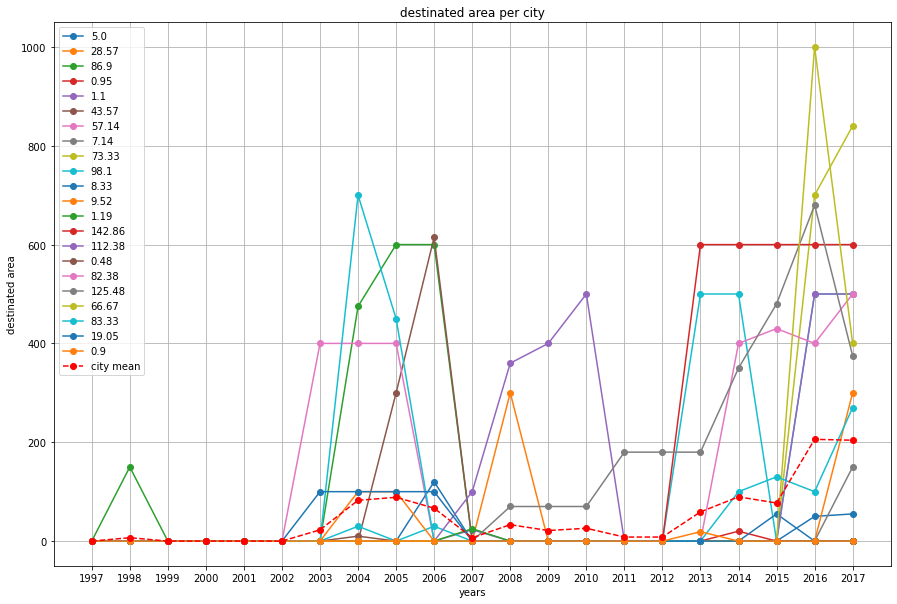

In [27]:
#The missing values is well distribuited.
#Let`s look a graph with line with non null values in extern_time_series for Soy that have mean in [0,150]
def graph_soy(extern_time_series,inferior_limit,superior_limit):
    not_na_line = []
    for key,line in extern_time_series.loc[extern_time_series['product'] == 'Soy'].loc[extern_time_series['mean'] != 0 ]\
        .loc[extern_time_series['mean'] < superior_limit ].loc[extern_time_series['mean'] >= inferior_limit ].iloc[:,1:22].isna().iterrows():
        null_line = True
        for i in range(21):
            if line.iloc[i] == False:
                null_line = False
        if ~null_line:
            not_na_line.append(key)

    #Plot the graph
    plt.figure(figsize = (15,10))
    plt.xlabel('years')
    plt.ylabel('destinated area')
    plt.title('destinated area per city')

    legends = []
    for key,line in extern_time_series.loc[not_na_line,:].iterrows():
        plt.plot(np.arange(1997,2018,step = 1),line.iloc[1:22],marker = 'o')
        legends.append(round(line['mean'],2))
    mean = extern_time_series.loc[not_na_line,:].iloc[:,1:22].mean()

    plt.plot(np.arange(1997,2018,step = 1),mean,'r--', marker = 'o')
    legends.append('city mean')

    #Plot graphic
    plt.grid()
    plt.legend(legends)
    plt.xticks(np.arange(1997,2018,step = 1))
    plt.show()
    return mean

mean = graph_soy(extern_time_series,0,150)

In [28]:
#Imput this city mean in the lines that have mean under 150
for key,line in part_2_time_series.loc[part_2_time_series['mean'] < 150].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

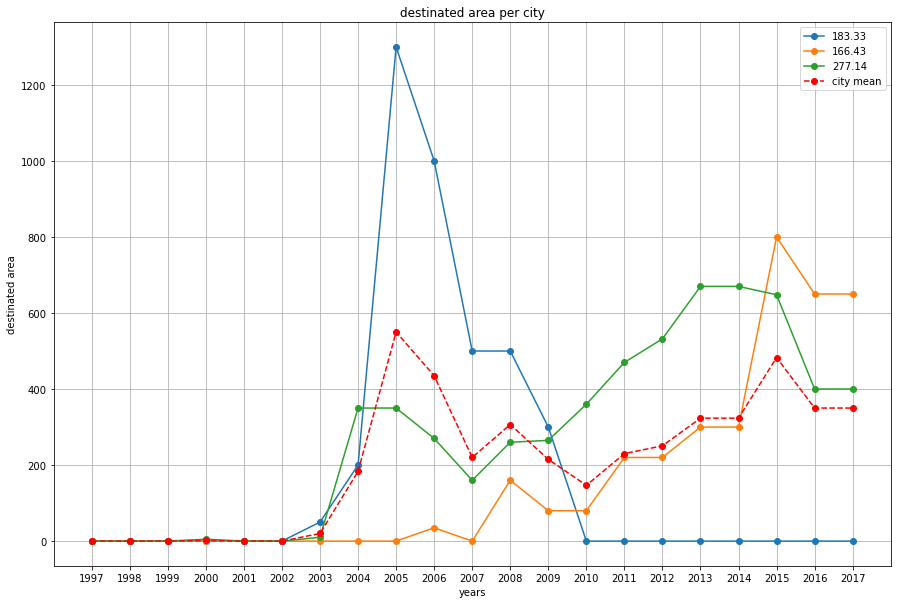

In [29]:
#Let`s look a graph with line with non null values in extern_time_series for Soy that have mean in [150,300]
mean = graph_soy(extern_time_series,150,300)

In [30]:
#Imput this city mean in the lines that have mean under 150
for key,line in part_2_time_series.loc[part_2_time_series['mean'] < 300].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

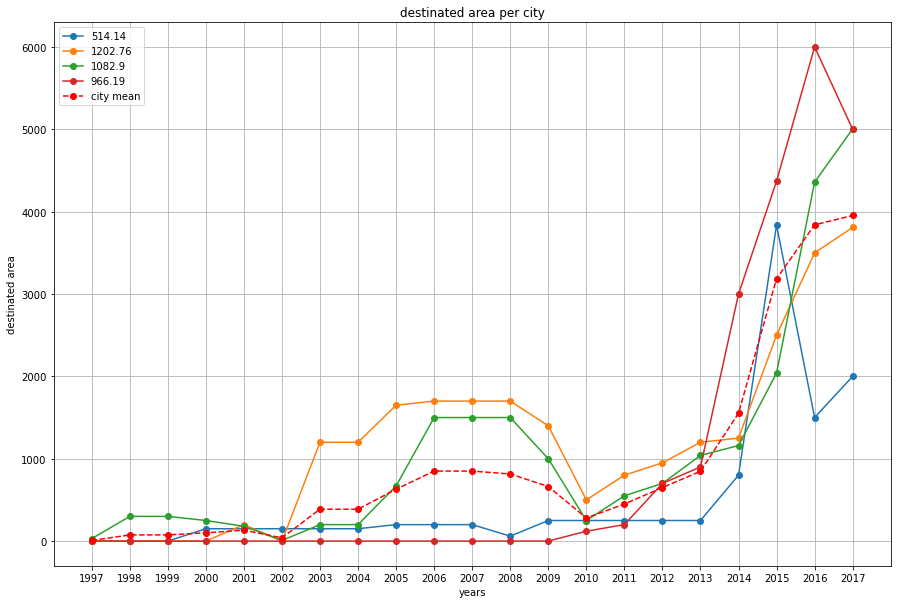

In [31]:
#Let`s look a graph with line with non null values in extern_time_series for Soy that have mean in [500,1500]
mean = graph_soy(extern_time_series,500,1500)

In [32]:
#Imput this city mean in the lines that have mean under 1500
for key,line in part_2_time_series.loc[part_2_time_series['mean'] < 1500].loc[part_2_time_series['mean'] > 500].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

In [33]:
#The rest of the lines we will imput with linear regression
for key,line in part_2_time_series.fillna(-1).iterrows():
    missing_values = set()
    need_linear_regression = False
    for position in range(0,21):
        if line.iloc[position] == -1:
            need_linear_regression = True
            missing_values.add(position)
    if need_linear_regression:
        x = list({i for i in range(0,21)} - missing_values)
        y = line.iloc[x]
        line = LinearRegression()
        line.fit(np.array(x).reshape(-1,1),y)
        results = line.predict(np.array(list(missing_values)).reshape(-1,1))
        for x_position,result in zip(list(missing_values),list(results)):
            if result < 0:
                part_2_time_series.loc[key,str(x_position)] = 0
            else:
                part_2_time_series.loc[key,str(x_position)] = result

#Concatenate with the rest of df
time_series = pd.concat([part_2_time_series,part_3_time_series,part_1_time_series,time_series])

Açaí

In [34]:
#Deal with Açaí
extern_time_series.loc[extern_time_series['product'] == 'Açaí'].isna().mean()

city_code    0.000000
1997         1.000000
1998         1.000000
1999         1.000000
2000         1.000000
2001         1.000000
2002         1.000000
2003         1.000000
2004         1.000000
2005         1.000000
2006         1.000000
2007         1.000000
2008         1.000000
2009         1.000000
2010         1.000000
2011         1.000000
2012         1.000000
2013         1.000000
2014         1.000000
2015         0.034965
2016         0.020979
2017         0.000000
product      0.000000
mean         0.000000
dtype: float64

In [35]:
time_series.loc[time_series['product'] == 'Açaí'].isna().mean()

0               0.958042
1               0.888112
2               0.923077
3               0.888112
4               0.888112
5               0.951049
6               0.916084
7               0.923077
8               0.888112
9               0.902098
10              0.853147
11              0.839161
12              0.895105
13              0.874126
14              0.930070
15              0.874126
16              0.895105
17              0.944056
18              0.951049
19              0.902098
20              0.881119
city_code       0.000000
product         0.000000
product_type    0.000000
mean            0.258741
dtype: float64

In [36]:
#We only can complete this data in 2015,2016 and 2017
acai = time_series.loc[time_series['product'] == 'Açaí'].iloc[:,[18,19,20]].copy()
time_series_acai = time_series.loc[time_series['product'] == 'Açaí'].copy()
time_series = time_series.loc[time_series['product'] != 'Açaí']

In [37]:
#Export this datasets to compare in a csv file, it`s easier to look,because don`t have a lot of lines
extern_time_series.loc[extern_time_series['product'] == 'Açaí'].iloc[:,[19,20,21]].to_csv('view_dataset/extern_time_series_Açaí.csv', sep = ';') 
acai.to_csv('view_dataset/time_series_Açaí.csv',sep = ';')

In [38]:
#The cities that we don`t have any information we will imput 0
#Identify the lines that only have na values
na_line = []
for key,line in acai.iloc[:,0:3].isna().iterrows():
    null_line = True
    for i in range(3):
        if line.iloc[i] == False:
            null_line = False
    if null_line:
        na_line.append(key)

part_1_time_series = acai.loc[na_line,:].copy()
part_1_time_series = part_1_time_series.fillna(0)
part_2_time_series = acai.loc[list(set(acai.index)-set(na_line)),:].copy()   

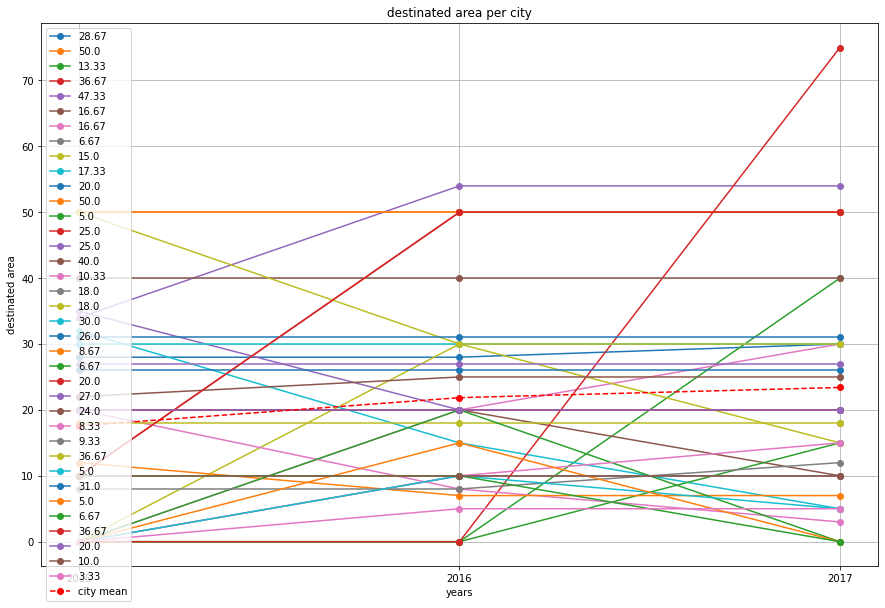

In [39]:
#Let`s look a graph with line with non null values in extern_time_series for Açaí that have mean in [0,50]
def graph_acai(extern_time_series,inferior_limit,superior_limit):
    not_na_line = []
    for key,line in extern_time_series.loc[extern_time_series['product'] == 'Açaí'].loc[extern_time_series['mean'] != 0 ]\
    .loc[extern_time_series['mean'] <= superior_limit ].loc[extern_time_series['mean'] > inferior_limit ].iloc[:,19:22].isna().iterrows():
        null_line = True
        for i in range(3):
            if line.iloc[i] == False:
                null_line = False
        if ~null_line:
            not_na_line.append(key)

    #Plot the graph
    plt.figure(figsize = (15,10))
    plt.xlabel('years')
    plt.ylabel('destinated area')
    plt.title('destinated area per city')

    legends = []
    for key,line in extern_time_series.loc[not_na_line,:].iterrows():
        plt.plot(np.arange(2015,2018,step = 1),line.iloc[19:22],marker = 'o')
        legends.append(round(line['mean'],2))
        
    mean = extern_time_series.loc[not_na_line,:].iloc[:,19:22].mean()

    plt.plot(np.arange(2015,2018,step = 1),mean,'r--', marker = 'o')
    legends.append('city mean')

    #Plot graphic
    plt.grid()
    plt.legend(legends)
    plt.xticks(np.arange(2015,2018,step = 1))
    plt.show()
    return mean

mean = graph_acai(extern_time_series,0,50)

In [40]:
#Let`s replace with the city mean
part_2_time_series.loc[:,'mean'] = 0
for key,line in part_2_time_series.iterrows():
    part_2_time_series.loc[key,'mean'] = line.iloc[0:3].mean()

for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 50].isna().iterrows():
    for position in range(3):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position + 18)] = mean[position]

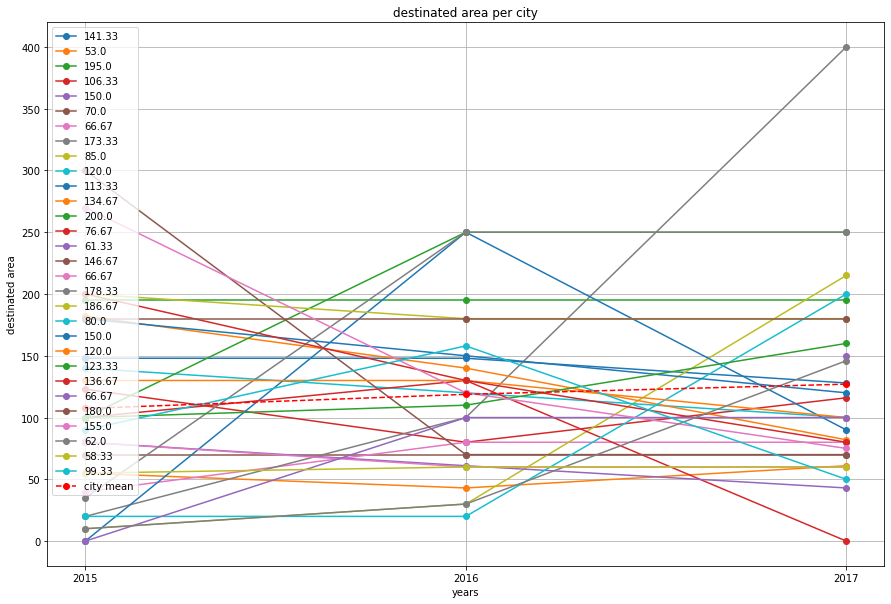

In [41]:
#Let`s look a graph with line with non null values in extern_time_series for Açaí that have mean in [50,200]
mean = graph_acai(extern_time_series,50,200)

In [42]:
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 200].isna().iterrows():
    for position in range(3):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position + 18)] = mean[position]

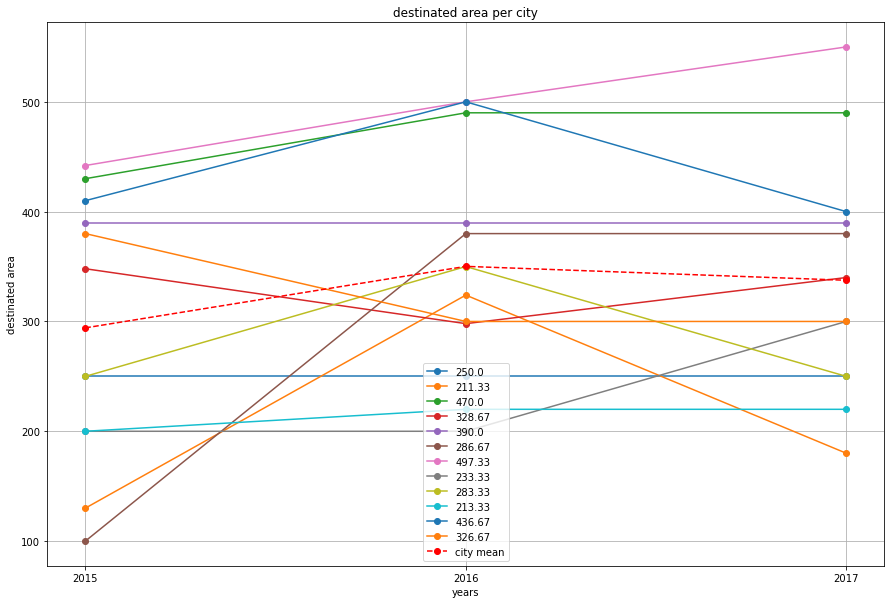

In [43]:
#Let`s look a graph with line with non null values in extern_time_series for Açaí that have meain in [200,500]
mean = graph_acai(extern_time_series,200,500)

In [44]:
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 500].isna().iterrows():
    for position in range(3):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position + 18)] = mean[position]

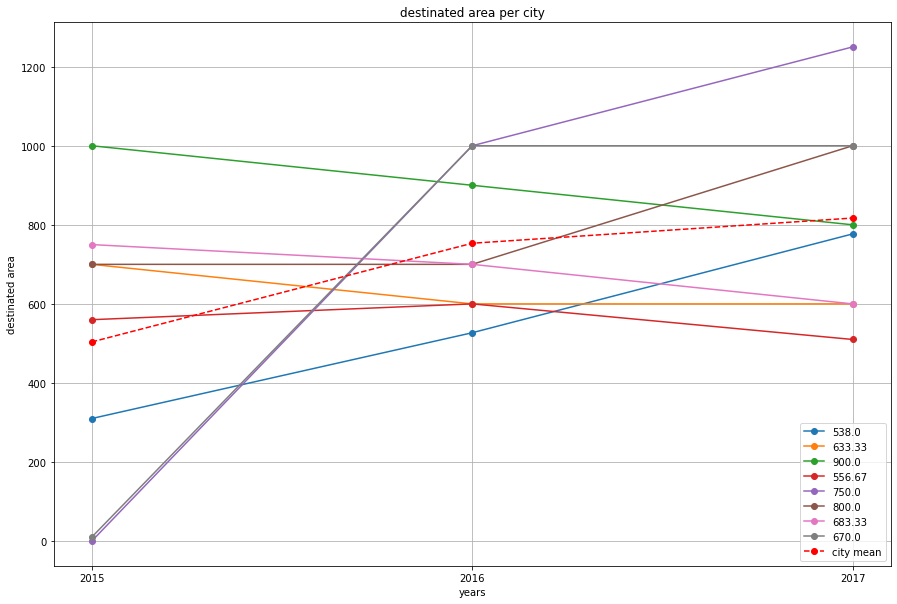

In [45]:
#Let`s look a graph with line with non null values in extern_time_series for Açaí that have mean in [500,1000]
mean = graph_acai(extern_time_series,500,1000)

In [46]:
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 1000].isna().iterrows():
    for position in range(3):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position + 18)] = mean[position]

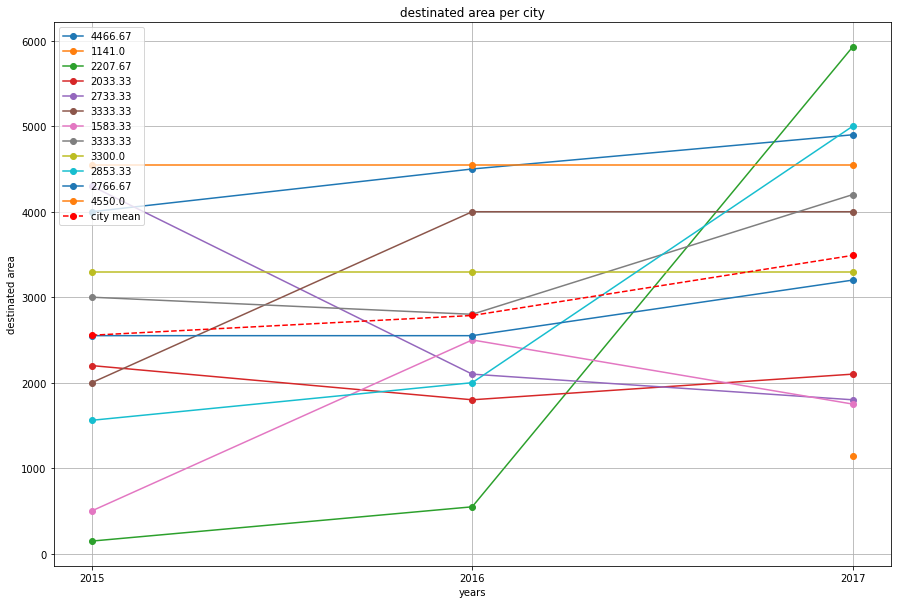

In [47]:
#Let`s look a graph with line with non null values in extern_time_series for Açaí that have mean in [1000,5000]
mean = graph_acai(extern_time_series,1000,5000)

In [48]:
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 5000].isna().iterrows():
    for position in range(3):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position + 18)] = mean[position]

In [49]:
#Look at dataframe
part_2_time_series

,18,19,20,mean
110/Açaí/permanent,2555.181818,2786.181818,3300.000000,3300
62/Açaí/permanent,2555.181818,2786.181818,4000.000000,4000
66/Açaí/permanent,7.000000,7.000000,23.405405,7
140/Açaí/permanent,2555.181818,2100.000000,3489.083333,2100
117/Açaí/permanent,2555.181818,1750.000000,3489.083333,1750
143/Açaí/permanent,107.344828,118.793103,110.000000,110
107/Açaí/permanent,17.583333,27.000000,23.405405,27
14/Açaí/permanent,503.750000,900.000000,817.125000,900
27/Açaí/permanent,1800.000000,2786.181818,3489.083333,1800
43/Açaí/permanent,700.000000,753.375000,817.125000,700


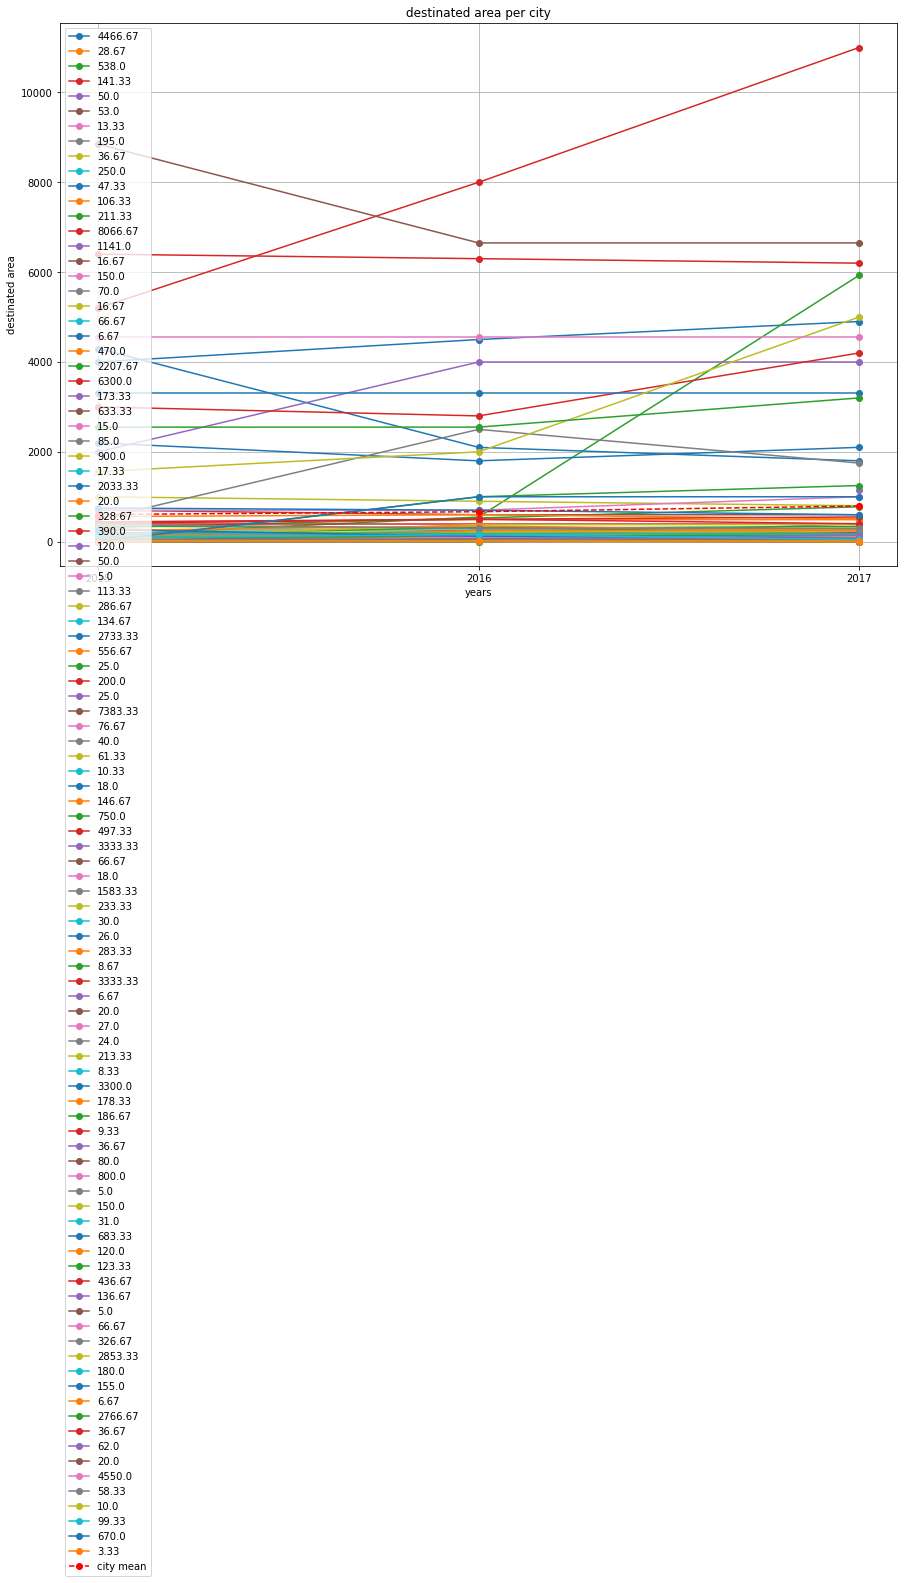

In [50]:
#To imput this 2 lines, let`s look at the behavior of acai
_ = graph_acai(extern_time_series,0,10000)

In [51]:
#We notice that the stadard behavior is to mantain constant, so we will imput the two lines to mantain constant
for i in range(3):
    part_2_time_series.loc['54/Açaí/permanent',str(i+18)] = 35800
    part_2_time_series.loc['130/Açaí/permanent',str(i+18)] = 5200

In [52]:
#Check if remain a nan line
part_2_time_series.isna().mean()

18      0.0
19      0.0
20      0.0
mean    0.0
dtype: float64

In [53]:
#Concatenate in time series
acai = pd.concat([part_1_time_series,part_2_time_series]).iloc[:,[0,1,2]]

In [54]:
#Complete the time_series_acai
for key,line in time_series_acai.iterrows():
    for position in range(21):
        if position < 18:
            time_series_acai.loc[key,str(position)] = np.NaN
        else:
           time_series_acai.loc[key,str(position)] = acai.loc[key,str(position)] 

Cocoa

In [55]:
#Look at Cocoa
extern_time_series.loc[extern_time_series['product'] == 'Cocoa'].isna().mean()

city_code    0.000000
1997         0.013986
1998         0.006993
1999         0.013986
2000         0.006993
2001         0.006993
2002         0.034965
2003         0.034965
2004         0.048951
2005         0.048951
2006         0.034965
2007         0.013986
2008         0.048951
2009         0.041958
2010         0.041958
2011         0.013986
2012         0.013986
2013         0.013986
2014         0.027972
2015         0.034965
2016         0.020979
2017         0.000000
product      0.000000
mean         0.000000
dtype: float64

In [56]:
#Split the dataset
cocoa = time_series.loc[time_series['product'] == 'Cocoa'].copy()
time_series = time_series.loc[time_series['product'] != 'Cocoa']

#Export this datasets to compare in a csv file, it`s easier to look,because don`t have a lot of lines
extern_time_series.loc[extern_time_series['product'] == 'Cocoa'].to_csv('view_dataset/extern_time_series_Cocoa.csv', sep = ';') 
cocoa.to_csv('view_dataset/time_series_Cocoa.csv',sep = ';')

In [57]:
#Imput 0
#Identify the lines that only have na values
na_line = []
for key,line in cocoa.iloc[:,0:21].isna().iterrows():
    null_line = True
    for i in range(21):
        if line.iloc[i] == False:
            null_line = False
    if null_line:
        na_line.append(key)

part_1_time_series = cocoa.loc[na_line,:].copy()
part_1_time_series = part_1_time_series.fillna(0)
part_2_time_series = cocoa.loc[list(set(cocoa.index)-set(na_line)),:].copy()    

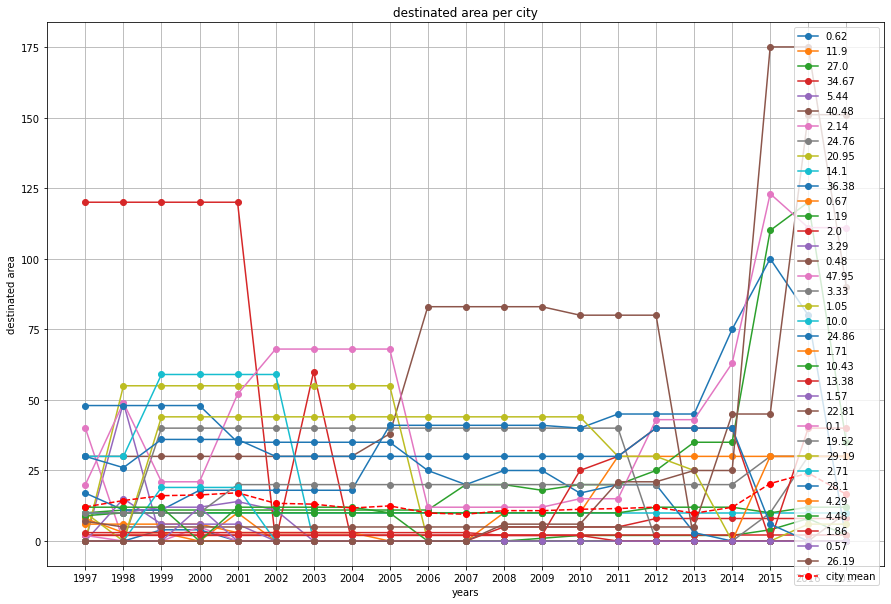

In [58]:
#The missing values is well distribuited.
#Let`s look a graph with line with non null values in extern_time_series for Cocoa that have meain in [0,50]
def graph_cocoa(extern_time_series,inferior_limit,superior_limit):
    not_na_line = []
    for key,line in extern_time_series.loc[extern_time_series['product'] == 'Cocoa'].loc[extern_time_series['mean'] != 0 ]\
        .loc[extern_time_series['mean'] < superior_limit ].loc[extern_time_series['mean'] >= inferior_limit ].iloc[:,1:22].isna().iterrows():
        null_line = True
        for i in range(21):
            if line.iloc[i] == False:
                null_line = False
        if ~null_line:
            not_na_line.append(key)

    #Plot the graph
    plt.figure(figsize = (15,10))
    plt.xlabel('years')
    plt.ylabel('destinated area')
    plt.title('destinated area per city')

    legends = []
    for key,line in extern_time_series.loc[not_na_line,:].iterrows():
        plt.plot(np.arange(1997,2018,step = 1),line.iloc[1:22],marker = 'o')
        legends.append(round(line['mean'],2))
    mean = extern_time_series.loc[not_na_line,:].iloc[:,1:22].mean()

    plt.plot(np.arange(1997,2018,step = 1),mean,'r--', marker = 'o')
    legends.append('city mean')

    #Plot graphic
    plt.grid()
    plt.legend(legends)
    plt.xticks(np.arange(1997,2018,step = 1))
    plt.show()
    return mean

mean = graph_cocoa(extern_time_series,0,50)

In [59]:
#Imput this city mean in the lines that have mean under 50
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 50].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

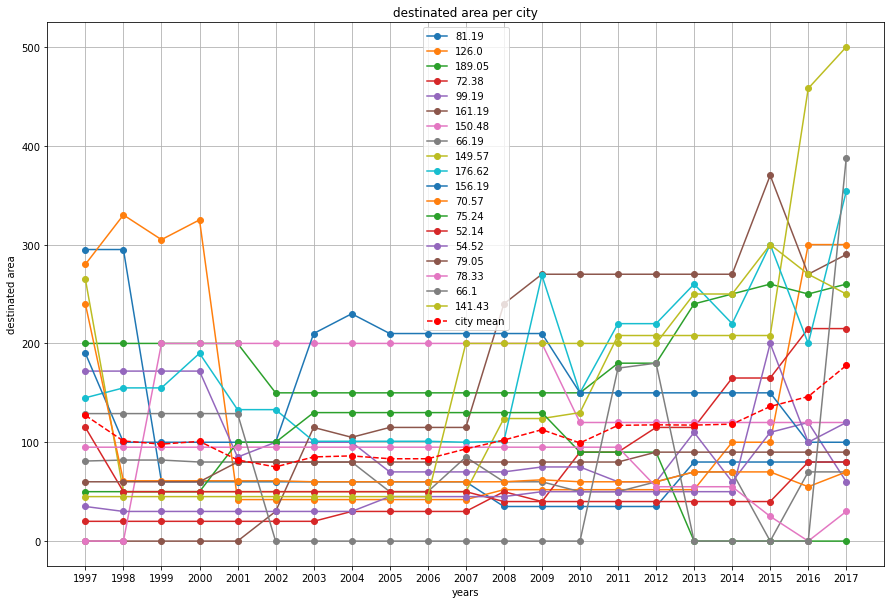

In [60]:
#Let`s look a graph with line with non null values in extern_time_series for Cocoa that have mean in [50,200]
mean = graph_cocoa(extern_time_series,50,200)

In [61]:
#Imput this city mean in the lines that have mean under 200
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 200].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

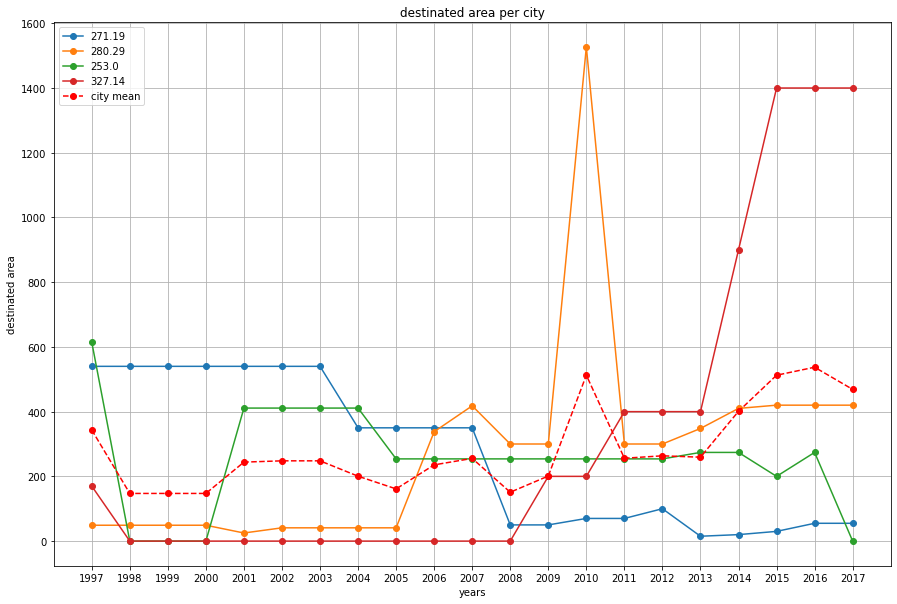

In [62]:
#Let`s look a graph with line with non null values in extern_time_series for Cocoa that have mean in [50,200]
mean = graph_cocoa(extern_time_series,200,500)

In [63]:
#Imput this city mean in the lines that have mean under 500
for key,line in part_2_time_series.loc[part_2_time_series['mean'] <= 500].isna().iterrows():
    for position in range(0,21):
        if line.iloc[position] == True:
            part_2_time_series.loc[key,str(position)] = mean[position]

In [64]:
#When we look in the csv, the lines that have mean higher than 500 is the lines that we have a lot of information
time_series = pd.concat([time_series,part_2_time_series,part_1_time_series]).iloc[:,0:24]

Time series

In [65]:
#Now we will imput the rest of the values with linear regression
na_line = []
for key,line in time_series.iloc[:,0:21].isna().iterrows():
    null_line = True
    for i in range(21):
        if line.iloc[i] == False:
            null_line = False
    if null_line:
        na_line.append(key)

part_1_time_series = time_series.loc[na_line,:].copy()
part_1_time_series = part_1_time_series.fillna(0)
part_2_time_series = time_series.loc[list(set(time_series.index)-set(na_line)),:].copy()
time_series = pd.concat([part_1_time_series,part_2_time_series])

for key,line in time_series.fillna(-1).iterrows():
    missing_values = set()
    need_linear_regression = False
    for position in range(0,21):
        if line.iloc[position] == -1:
            need_linear_regression = True
            missing_values.add(position)
    if need_linear_regression:
        x = list({i for i in range(0,21)} - missing_values)
        y = line.iloc[x]
        line = LinearRegression()
        line.fit(np.array(x).reshape(-1,1),y)
        results = line.predict(np.array(list(missing_values)).reshape(-1,1))
        for x_position,result in zip(list(missing_values),list(results)):
            if result < 0:
                time_series.loc[key,str(x_position)] = 0
            else:
                time_series.loc[key,str(x_position)] = result

In [66]:
for key,line in time_series_acai.iterrows():
    for position in range(21):
        if position < 18:
            time_series_acai.loc[key,str(position)] = np.NaN
        else:
           time_series_acai.loc[key,str(position)] = acai.loc[key,str(position)] 

In [67]:
#Convert timeseries to df
export_df = pd.DataFrame([],columns = ['destinated_area', 'city_code', 'product', 'product_type','year'])
for i in range(0,21):
    sub_df = time_series.iloc[:,[i,21,22,23]].copy()
    sub_df.loc[:,'year'] = str(1997 + i)
    sub_df.columns = ['destinated_area', 'city_code', 'product', 'product_type','year']
    export_df = pd.concat([export_df,sub_df])
export_df.reset_index(inplace = True)
export_df = export_df.iloc[:,1::]

In [68]:
#Convert acai to df
export_df_2 = pd.DataFrame([],columns = ['destinated_area', 'city_code', 'product', 'product_type','year'])
for i in range(18,21):
    sub_df = time_series_acai.iloc[:,[i,21,22,23]].copy()
    sub_df.loc[:,'year'] = str(1997 + i)
    sub_df.columns = ['destinated_area', 'city_code', 'product', 'product_type','year']
    export_df_2 = pd.concat([export_df_2,sub_df])
export_df_2.reset_index(inplace = True)
export_df_2 = export_df_2.iloc[:,1::]

In [69]:
#Concat and export time_series
time_series = pd.concat([time_series,time_series_acai])
time_series.iloc[:,0:24].to_csv('dataset/final_time_series.csv', sep = ';')

#Concat and export df
df = pd.concat([export_df,export_df_2])
df.to_csv('dataset/final_df.csv', sep = ';')

In [70]:
time_series.iloc[:,0:24]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,city_code,product,product_type
68/Rice/temporary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,773cbe24d8fc9fea,Rice,temporary
68/Corn/temporary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,773cbe24d8fc9fea,Corn,temporary
8/Rice/temporary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,09791645137aa877,Rice,temporary
76/Corn/temporary,11000.0,11000.0,6000.0,11000.0,3000.0,3000.0,4000.0,2500.0,400.0,500.0,...,1700.0,500.0,1500.0,2500.0,2500.0,400.0,3500.0,807c5037e6993f2c,Corn,temporary
143/Cassava/temporary,2970.0,2800.0,3000.0,3000.0,2800.0,2400.0,2800.0,1500.0,2840.0,1400.0,...,1500.0,1600.0,2000.0,1700.0,2000.0,2800.0,2300.0,fda49275fbf5caf6,Cassava,temporary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39/Açaí/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,480b0f80325080af,Açaí,permanent
111/Açaí/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,b73e63cd3a2904c9,Açaí,permanent
67/Açaí/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,764cd56389d50070,Açaí,permanent
72/Açaí/permanent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,7926ffd2861f8dbc,Açaí,permanent
